# K-Means Market Segmentation v0

Análisis exploratorio de segmentación de barrios de Barcelona usando K-Means sobre datos existentes en `database.db`.

Este notebook implementa el flujo descrito en la issue #217 ("[ANALYSIS] K-Means Market Segmentation v0 - Validation Framework").

## Objetivos

- Construir un dataset de features por barrio usando solo tablas existentes (dim_barrios, fact_demografia, fact_precios, fact_renta).
- Probar valores de \(k\) entre 2 y 10 con método del codo y Silhouette Score.
- Seleccionar un \(k_{opt}\) en el rango 3–5 con buena separación de clusters.
- Validar estabilidad vía bootstrap y analizar perfiles de cluster.
- Generar visualizaciones (mapa, perfiles, PCA, silhouette plot) y documentar resultados.



In [27]:
"""Notebook de segmentación de mercado K-Means v0.

Este notebook se apoya exclusivamente en la base de datos SQLite
`data/processed/database.db` y no modifica su contenido; solo realiza
consultas de lectura para análisis exploratorio.
"""

from __future__ import annotations

import logging
from pathlib import Path
from typing import List, Tuple

import numpy as np
import pandas as pd
import sqlite3

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from sklearn.utils import resample

# Opcional: visualización básica (puede ampliarse más adelante)
import matplotlib.pyplot as plt
import seaborn as sns

logging.basicConfig(level=logging.INFO)
logger = logging.getLogger("kmeans_market_segmentation")

# Detectar raíz del proyecto asumiendo que este notebook vive en notebooks/analysis/
# y que se ejecuta dentro del árbol del repositorio.
PROJECT_ROOT = Path.cwd().resolve().parents[1]
DB_PATH = PROJECT_ROOT / "data" / "processed" / "database.db"

logger.info(f"Usando base de datos en: {DB_PATH}")


def get_connection(db_path: Path = DB_PATH) -> sqlite3.Connection:
    """Devuelve una conexión SQLite solo-lectura a la base de datos del proyecto.

    Args:
        db_path: Ruta al archivo de base de datos SQLite.

    Returns:
        Conexión SQLite abierta.

    Raises:
        FileNotFoundError: Si la base de datos no existe.
    """
    if not db_path.exists():
        raise FileNotFoundError(f"No se encontró la base de datos en {db_path}")

    # Conexión estándar (este notebook no realiza escrituras)
    conn = sqlite3.connect(db_path)
    conn.execute("PRAGMA foreign_keys = ON;")
    return conn


INFO:kmeans_market_segmentation:Usando base de datos en: /Users/adrianiraeguialvear/Projects/barcelona-housing-demographics-analyzer/data/processed/database.db


In [28]:
def get_common_years(conn: sqlite3.Connection) -> List[int]:
    """Obtiene los años comunes presentes en las tablas factuales clave.

    La idea es identificar años donde existan datos tanto de demografía,
    precios y renta, para poder construir un dataset consistente por barrio.

    Args:
        conn: Conexión SQLite activa.

    Returns:
        Lista de años presentes en las tres tablas (ordenada ascendente).
    """
    queries = {
        "fact_demografia": "SELECT DISTINCT anio FROM fact_demografia",
        "fact_precios": "SELECT DISTINCT anio FROM fact_precios",
        "fact_renta": "SELECT DISTINCT anio FROM fact_renta",
    }

    years_sets: List[set[int]] = []
    for name, sql in queries.items():
        df = pd.read_sql_query(sql, conn)
        if df.empty:
            logger.warning("Tabla %s sin años disponibles", name)
            return []
        years_sets.append(set(df["anio"].dropna().astype(int)))

    if not years_sets:
        return []

    common_years = sorted(list(set.intersection(*years_sets)))
    logger.info("Años comunes en fact_demografia, fact_precios y fact_renta: %s", common_years)
    return common_years



In [29]:
def load_barrio_features(conn: sqlite3.Connection, year: int) -> pd.DataFrame:
    """Construye el DataFrame de features por barrio para un año dado.

    Features principales:
    - porc_inmigracion (fact_demografia)
    - poblacion_total (fact_demografia)
    - precio_mes_alquiler (fact_precios)
    - renta_mediana (fact_renta)
    - distancia_centro_km (calculada desde dim_barrios)

    Args:
        conn: Conexión SQLite activa.
        year: Año a filtrar en las tablas de hechos.

    Returns:
        DataFrame con una fila por barrio y columnas de features numéricos.
    """
    center_lat = 41.3874
    center_lon = 2.1686

    sql = """
    WITH demografia AS (
        SELECT
            barrio_id,
            anio,
            AVG(poblacion_total) AS poblacion_total,
            AVG(porc_inmigracion) AS porc_inmigracion
        FROM fact_demografia
        WHERE anio = :year
        GROUP BY barrio_id, anio
    ),
    precios AS (
        SELECT
            barrio_id,
            anio,
            AVG(precio_mes_alquiler) AS precio_mes_alquiler
        FROM fact_precios
        WHERE anio = :year
        GROUP BY barrio_id, anio
    ),
    renta AS (
        SELECT
            barrio_id,
            anio,
            AVG(renta_mediana) AS renta_mediana
        FROM fact_renta
        WHERE anio = :year
        GROUP BY barrio_id, anio
    )
    SELECT
        b.barrio_id,
        b.barrio_nombre AS barrio_nombre,
        b.codi_barri,
        b.centroide_lat,
        b.centroide_lon,
        d.poblacion_total,
        d.porc_inmigracion,
        p.precio_mes_alquiler,
        r.renta_mediana
    FROM dim_barrios b
    LEFT JOIN demografia d ON d.barrio_id = b.barrio_id
    LEFT JOIN precios p ON p.barrio_id = b.barrio_id
    LEFT JOIN renta r ON r.barrio_id = b.barrio_id
    """

    df = pd.read_sql_query(sql, conn, params={"year": year})

    if df.empty:
        logger.warning("No se obtuvieron datos para el año %s", year)
        return df

    # Calcular distancia al centro aproximando 1 grado ≈ 111 km
    def euclidean_distance_km(lat: float, lon: float) -> float:
        """Calcula distancia aproximada en km al centro de Barcelona.

        Args:
            lat: Latitud del barrio.
            lon: Longitud del barrio.

        Returns:
            Distancia aproximada en kilómetros.
        """
        if pd.isna(lat) or pd.isna(lon):
            return np.nan
        dlat = lat - center_lat
        dlon = lon - center_lon
        return float(np.sqrt(dlat**2 + dlon**2) * 111.0)

    df["distancia_centro_km"] = df.apply(
        lambda row: euclidean_distance_km(row["centroide_lat"], row["centroide_lon"]),
        axis=1,
    )

    # Seleccionar solo columnas necesarias para clustering
    feature_cols = [
        "poblacion_total",
        "porc_inmigracion",
        "precio_mes_alquiler",
        "renta_mediana",
        "distancia_centro_km",
    ]

    # Comprobar completitud mínima
    df_features = df[["barrio_id", "barrio_nombre", "codi_barri"] + feature_cols].copy()

    before = len(df_features)
    df_features = df_features.dropna(subset=feature_cols)
    after = len(df_features)

    logger.info(
        "Registros de barrios con datos completos para %s: %s/%s",
        year,
        after,
        before,
    )

    return df_features



In [30]:
# Ejecución inicial: seleccionar año y construir dataset de features

conn = get_connection()
common_years = get_common_years(conn)
common_years


INFO:kmeans_market_segmentation:Años comunes en fact_demografia, fact_precios y fact_renta: [2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023]


[2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023]

In [31]:
# Elegir año objetivo para el análisis
if not common_years:
    raise ValueError("No hay años comunes entre las tablas factuales")

target_year = max(common_years)
logger.info(f"Año objetivo seleccionado para clustering: {target_year}")

features_df = load_barrio_features(conn, target_year)
features_df.head(), len(features_df)

INFO:kmeans_market_segmentation:Año objetivo seleccionado para clustering: 2023
INFO:kmeans_market_segmentation:Registros de barrios con datos completos para 2023: 71/73


(   barrio_id                          barrio_nombre codi_barri  \
 0          1                               el Raval         01   
 1          2                         el Barri Gòtic         02   
 2          3                         la Barceloneta         03   
 3          4  Sant Pere, Santa Caterina i la Ribera         04   
 4          5                          el Fort Pienc         05   
 
    poblacion_total  porc_inmigracion  precio_mes_alquiler  renta_mediana  \
 0          45671.0          4.747967           946.812913        31729.0   
 1          24460.0          4.083299          1265.379381        36301.0   
 2          14274.0          2.813405           991.029534        33156.0   
 3          22041.0          5.401406          1065.792148        34693.0   
 4          34403.0          1.289802          1155.848290        50325.5   
 
    distancia_centro_km  
 0             1.518031  
 1             1.507122  
 2             2.752911  
 3             1.900738  
 4

## TODO siguiente

- Elegir un año objetivo (por ejemplo, el último de `common_years`) y generar el DataFrame final de features.
- Normalizar las columnas numéricas con `StandardScaler`.
- Implementar búsqueda de \(k\) (2–10) con método del codo y Silhouette Score.
- Seleccionar \(k_{opt}\) en el rango 3–5 y entrenar el modelo final.
- Implementar bootstrap (100 iteraciones) y análisis de perfiles de cluster.
- Generar visualizaciones (mapa, perfiles, PCA, silhouette plot) y documentarlas en `docs/analysis/MARKET_SEGMENTATION_V0_RESULTS.md`.



In [32]:
# Preparar matriz de features para clustering

feature_cols = [
    "poblacion_total",
    "porc_inmigracion",
    "precio_mes_alquiler",
    "renta_mediana",
    "distancia_centro_km",
]

if "features_df" not in globals():
    raise RuntimeError(
        "Se requiere un DataFrame 'features_df' con las columnas de features calculadas."
    )

X = features_df[feature_cols].values.astype(float)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

logger.info(
    "Matriz de features preparada: %s barrios, %s variables",
    X_scaled.shape[0],
    X_scaled.shape[1],
)


INFO:kmeans_market_segmentation:Matriz de features preparada: 71 barrios, 5 variables


INFO:kmeans_market_segmentation:k=2 -> silhouette=0.330, inertia=241.66
INFO:kmeans_market_segmentation:k=3 -> silhouette=0.393, inertia=166.33
INFO:kmeans_market_segmentation:k=4 -> silhouette=0.286, inertia=131.76
INFO:kmeans_market_segmentation:k=5 -> silhouette=0.287, inertia=110.28
INFO:kmeans_market_segmentation:k=6 -> silhouette=0.291, inertia=95.16
INFO:kmeans_market_segmentation:k=7 -> silhouette=0.281, inertia=82.62
INFO:kmeans_market_segmentation:k=8 -> silhouette=0.261, inertia=76.82
INFO:kmeans_market_segmentation:k=9 -> silhouette=0.268, inertia=68.24
INFO:kmeans_market_segmentation:k=10 -> silhouette=0.264, inertia=61.91


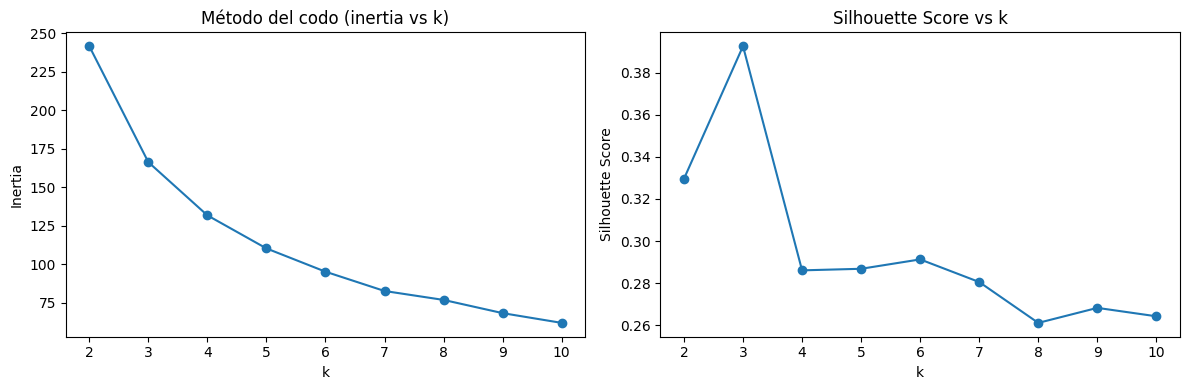

{2: 0.32957780186856744,
 3: 0.39262959595601415,
 4: 0.2860656643010959,
 5: 0.28681311686190286,
 6: 0.2912715022161577,
 7: 0.2805171049201858,
 8: 0.2610961347331281,
 9: 0.2682334549072905,
 10: 0.26422959746119495}

In [33]:
# Búsqueda de número óptimo de clusters (k) con Elbow + Silhouette

k_values = list(range(2, 11))
inertias = []
silhouette_scores = []

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(X_scaled)
    inertias.append(kmeans.inertia_)
    score = silhouette_score(X_scaled, labels)
    silhouette_scores.append(score)
    logger.info("k=%s -> silhouette=%.3f, inertia=%.2f", k, score, kmeans.inertia_)

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

axes[0].plot(k_values, inertias, marker="o")
axes[0].set_xlabel("k")
axes[0].set_ylabel("Inertia")
axes[0].set_title("Método del codo (inertia vs k)")

axes[1].plot(k_values, silhouette_scores, marker="o")
axes[1].set_xlabel("k")
axes[1].set_ylabel("Silhouette Score")
axes[1].set_title("Silhouette Score vs k")

plt.tight_layout()
plt.show()

silhouette_by_k = dict(zip(k_values, silhouette_scores))
silhouette_by_k


In [34]:
# Seleccionar k_opt dando prioridad al rango 3-5 si es posible

preferred_range = [k for k in k_values if 3 <= k <= 5]

if preferred_range:
    k_opt = max(preferred_range, key=lambda k: silhouette_by_k[k])
else:
    k_opt = max(k_values, key=lambda k: silhouette_by_k[k])

logger.info("k_opt seleccionado: %s (Silhouette=%.3f)", k_opt, silhouette_by_k[k_opt])

kmeans_opt = KMeans(n_clusters=k_opt, random_state=42, n_init=10)
labels_opt = kmeans_opt.fit_predict(X_scaled)

features_df["cluster_label"] = labels_opt
features_df.head()


INFO:kmeans_market_segmentation:k_opt seleccionado: 3 (Silhouette=0.393)


,barrio_id,barrio_nombre,codi_barri,poblacion_total,porc_inmigracion,precio_mes_alquiler,renta_mediana,distancia_centro_km,cluster_label
0,1,el Raval,01,45671.0,4.747967,946.812913,31729.0,1.518031,1
1,2,el Barri Gòtic,02,24460.0,4.083299,1265.379381,36301.0,1.507122,1
2,3,la Barceloneta,03,14274.0,2.813405,991.029534,33156.0,2.752911,1
3,4,"Sant Pere, Santa Caterina i la Ribera",04,22041.0,5.401406,1065.792148,34693.0,1.900738,1
4,5,el Fort Pienc,05,34403.0,1.289802,1155.848290,50325.5,1.558346,1


### Siguiente bloque sugerido

- Implementar bootstrap de estabilidad (100 iteraciones) usando `k_opt`.
- Calcular estadísticas de los Silhouette Scores (media, std, CV) y verificar que CV < 15%.
- Generar tabla de perfiles de cluster (medias de cada feature por `cluster_label`).
- Definir etiquetas cualitativas para cada cluster.
- Implementar visualizaciones (mapa, perfiles normalizados, PCA, silhouette plot).
- Volcar un resumen preliminar de resultados en `docs/analysis/MARKET_SEGMENTATION_V0_RESULTS.md`.



INFO:kmeans_market_segmentation:Bootstrap Silhouette -> mean=0.401, std=0.058, CV=14.54%


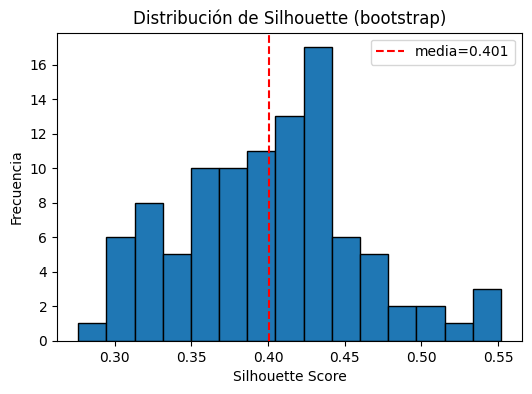

(0.4005329797837229, 0.058252448759610546, 14.543733400197237)

In [35]:
# Bootstrap de estabilidad para k_opt

if "k_opt" not in globals() or "labels_opt" not in globals():
    raise RuntimeError("Se requiere haber ajustado previamente el modelo K-Means óptimo.")

n_bootstrap = 100
silhouette_bootstrap: list[float] = []

for i in range(n_bootstrap):
    X_sample = resample(X_scaled, replace=True, random_state=42 + i)
    kmeans_bs = KMeans(n_clusters=k_opt, random_state=42 + i, n_init=10)
    labels_bs = kmeans_bs.fit_predict(X_sample)
    score_bs = silhouette_score(X_sample, labels_bs)
    silhouette_bootstrap.append(score_bs)

silhouette_bootstrap = np.array(silhouette_bootstrap)
mean_sil = float(silhouette_bootstrap.mean())
std_sil = float(silhouette_bootstrap.std(ddof=1))
cv_sil = float(std_sil / mean_sil * 100.0)

logger.info(
    "Bootstrap Silhouette -> mean=%.3f, std=%.3f, CV=%.2f%%",
    mean_sil,
    std_sil,
    cv_sil,
)

fig, ax = plt.subplots(figsize=(6, 4))
ax.hist(silhouette_bootstrap, bins=15, edgecolor="black")
ax.axvline(mean_sil, color="red", linestyle="--", label=f"media={mean_sil:.3f}")
ax.set_title("Distribución de Silhouette (bootstrap)")
ax.set_xlabel("Silhouette Score")
ax.set_ylabel("Frecuencia")
ax.legend()
plt.show()

mean_sil, std_sil, cv_sil


In [36]:
# Perfiles de cluster (media de features por cluster)

cluster_profiles = (
    features_df
    .groupby("cluster_label")[feature_cols]
    .mean()
    .sort_index()
)

cluster_sizes = features_df["cluster_label"].value_counts().sort_index()

logger.info("Tamaño de clusters: %s", cluster_sizes.to_dict())

cluster_profiles


INFO:kmeans_market_segmentation:Tamaño de clusters: {0: 45, 1: 19, 2: 7}


,poblacion_total,porc_inmigracion,precio_mes_alquiler,renta_mediana,distancia_centro_km
cluster_label,,,,,
0,17994.155556,0.302369,906.602521,39582.288889,5.144139
1,38951.894737,2.757874,1145.041870,47647.394737,2.472493
2,15288.714286,0.634062,1536.788633,83726.928571,6.426662


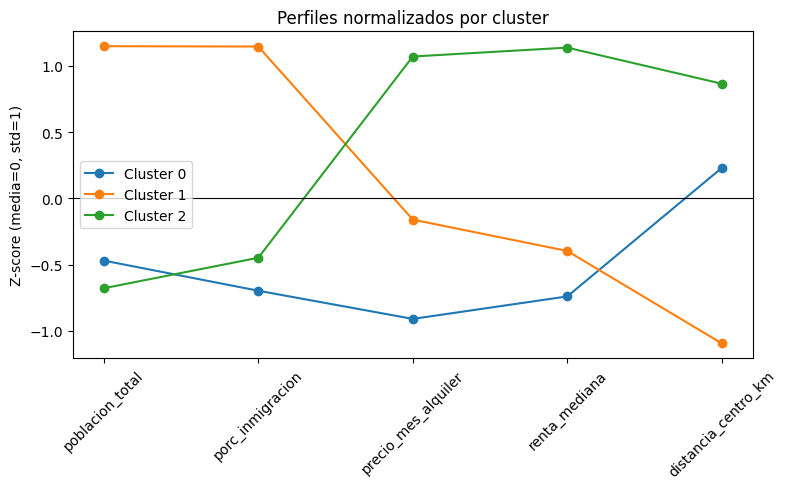

In [37]:
# Visualización rápida de perfiles normalizados por cluster

profiles_norm = (cluster_profiles - cluster_profiles.mean()) / cluster_profiles.std()

plt.figure(figsize=(8, 5))
for cluster_label, row in profiles_norm.iterrows():
    plt.plot(feature_cols, row.values, marker="o", label=f"Cluster {cluster_label}")

plt.axhline(0, color="black", linewidth=0.8)
plt.xticks(rotation=45)
plt.ylabel("Z-score (media=0, std=1)")
plt.title("Perfiles normalizados por cluster")
plt.legend()
plt.tight_layout()
plt.show()


### Interpretación preliminar

- Usar la tabla `cluster_profiles` y el gráfico de perfiles normalizados para:
  - Identificar qué cluster agrupa barrios céntricos y caros.
  - Cuál tiene mayor `porc_inmigracion` y menor `renta_mediana` (barrios populares).
  - Cuál está más alejado del centro (`distancia_centro_km`) con renta/media distintas.
- Con esta información, redactar etiquetas cualitativas para cada cluster en el informe:
  - Ejemplo: "Centro histórico - Alto valor - Turístico", "Barrios populares - Inmigración".
- Registrar en `docs/analysis/MARKET_SEGMENTATION_V0_RESULTS.md` el valor de:
  - `k_opt`, Silhouette global, media/std/CV bootstrap y tamaño de clusters.



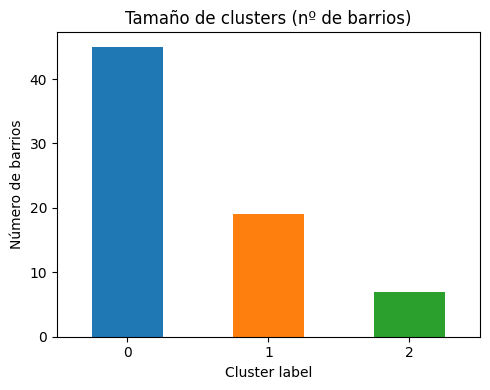

In [38]:
# Distribución de tamaños de cluster

plt.figure(figsize=(5, 4))
cluster_sizes.plot(kind="bar", color=["C0", "C1", "C2"])
plt.xlabel("Cluster label")
plt.ylabel("Número de barrios")
plt.title("Tamaño de clusters (nº de barrios)")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


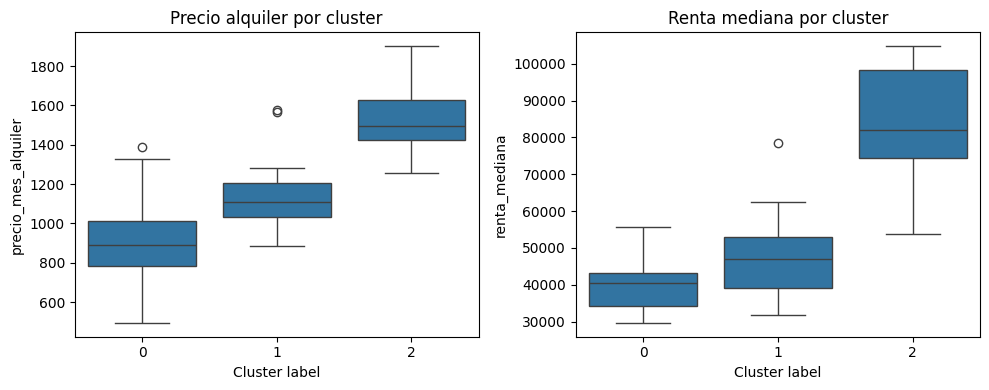

In [39]:
# Boxplots de precio de alquiler y renta por cluster

fig, axes = plt.subplots(1, 2, figsize=(10, 4))

sns.boxplot(
    data=features_df,
    x="cluster_label",
    y="precio_mes_alquiler",
    ax=axes[0],
)
axes[0].set_title("Precio alquiler por cluster")
axes[0].set_xlabel("Cluster label")
axes[0].set_ylabel("precio_mes_alquiler")

sns.boxplot(
    data=features_df,
    x="cluster_label",
    y="renta_mediana",
    ax=axes[1],
)
axes[1].set_title("Renta mediana por cluster")
axes[1].set_xlabel("Cluster label")
axes[1].set_ylabel("renta_mediana")

plt.tight_layout()
plt.show()


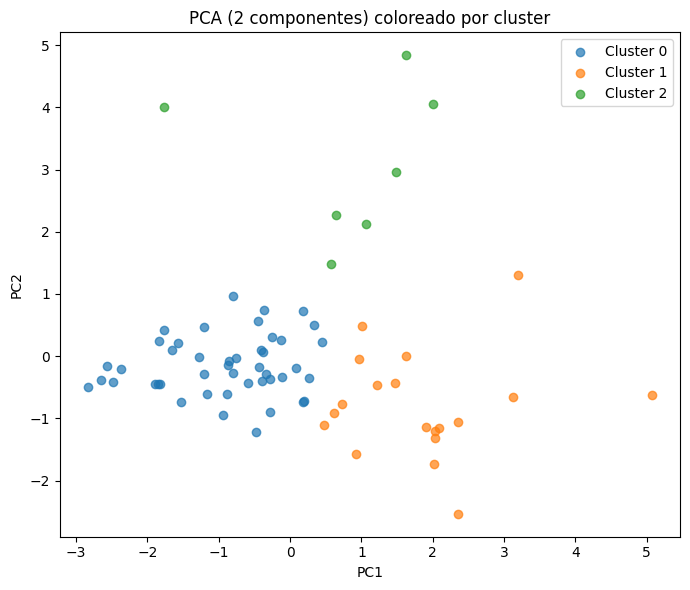

array([0.48512247, 0.31593082])

In [40]:
# PCA 2D scatter coloreado por cluster

pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_scaled)

pca_df = pd.DataFrame(
    X_pca,
    columns=["PC1", "PC2"],
)
pca_df["cluster_label"] = features_df["cluster_label"].values
pca_df["barrio_nombre"] = features_df["barrio_nombre"].values

plt.figure(figsize=(7, 6))
for label in sorted(pca_df["cluster_label"].unique()):
    subset = pca_df[pca_df["cluster_label"] == label]
    plt.scatter(
        subset["PC1"],
        subset["PC2"],
        label=f"Cluster {label}",
        alpha=0.7,
    )

plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("PCA (2 componentes) coloreado por cluster")
plt.legend()
plt.tight_layout()
plt.show()

pca.explained_variance_ratio_


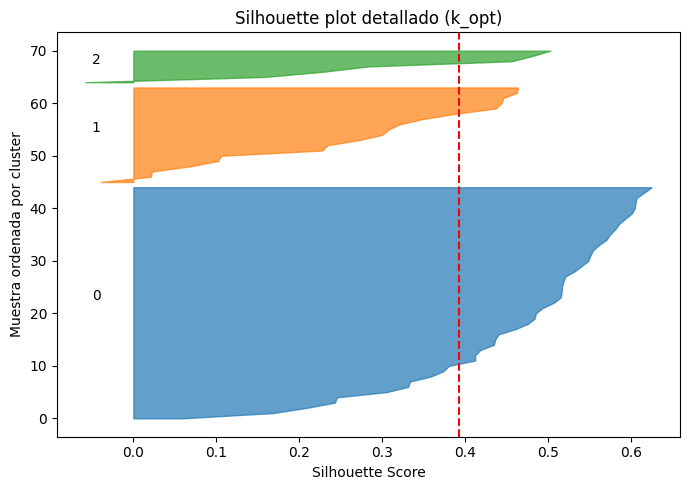

In [41]:
# Silhouette plot detallado por observación

from sklearn.metrics import silhouette_samples

silhouette_vals = silhouette_samples(X_scaled, labels_opt)

fig, ax = plt.subplots(figsize=(7, 5))
y_lower = 0

for cluster in sorted(np.unique(labels_opt)):
    cluster_sil_vals = silhouette_vals[labels_opt == cluster]
    cluster_sil_vals.sort()
    size_cluster = cluster_sil_vals.shape[0]
    y_upper = y_lower + size_cluster
    color = plt.cm.tab10(cluster)
    ax.fill_betweenx(
        np.arange(y_lower, y_upper),
        0,
        cluster_sil_vals,
        facecolor=color,
        edgecolor=color,
        alpha=0.7,
    )
    ax.text(-0.05, y_lower + 0.5 * size_cluster, str(cluster))
    y_lower = y_upper

ax.axvline(silhouette_score(X_scaled, labels_opt), color="red", linestyle="--")
ax.set_xlabel("Silhouette Score")
ax.set_ylabel("Muestra ordenada por cluster")
ax.set_title("Silhouette plot detallado (k_opt)")
plt.tight_layout()
plt.show()


### Visualizaciones añadidas

- Distribución del tamaño de los clusters.
- Boxplots de `precio_mes_alquiler` y `renta_mediana` por cluster.
- Proyección PCA en 2D coloreada por `cluster_label`.
- Silhouette plot detallado para \(k_{opt} = 3\).

Estas figuras pueden exportarse fácilmente a `outputs/visualizations/` si se
requiere para el dashboard o para informes adicionales.

